In [2]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.spatial.distance import pdist, squareform
import random
from scipy.stats import norm


## 1.2 Environment Setup

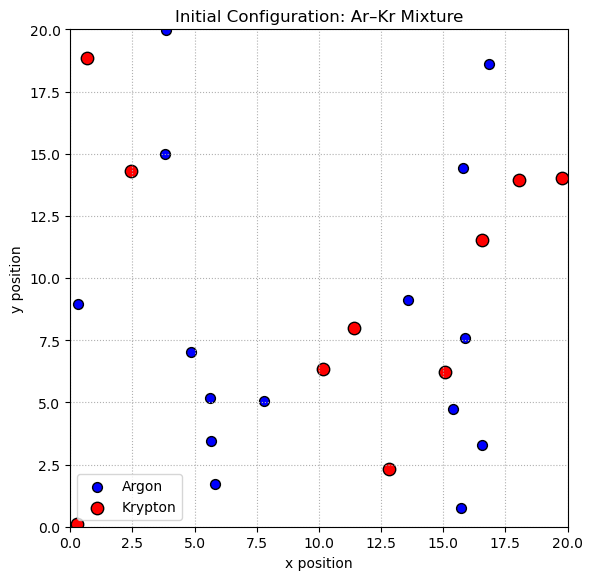

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters 
box_size = 20
n_argon = 15
n_krypton = 10
total_atoms = n_argon + n_krypton
min_separation = 1.0

# Initialize positions
positions = np.zeros((total_atoms, 2))

# Random velocities
velocities = np.random.normal(0.0, 1.0, size=(total_atoms, 2))

# Remove center-of-mass drift
velocities -= velocities.mean(axis=0)

# Atom labels: 0 = Argon, 1 = Krypton
labels = np.array([0]*n_argon + [1]*n_krypton)


for i in range(total_atoms):
    while True:
        x_trial = np.random.uniform(0, box_size)
        y_trial = np.random.uniform(0, box_size)

        ok = True
        for j in range(i):
            dx = x_trial - positions[j, 0]
            dy = y_trial - positions[j, 1]
            r = np.sqrt(dx*dx + dy*dy)

            if r < min_separation:
                ok = False
                break

        if ok:
            positions[i, 0] = x_trial
            positions[i, 1] = y_trial
            break


plt.figure(figsize=(6, 6))

plt.scatter(
    positions[labels == 0, 0],
    positions[labels == 0, 1],
    s=50,
    c="blue",
    edgecolors="black",
    label="Argon"
)

plt.scatter(
    positions[labels == 1, 0],
    positions[labels == 1, 1],
    s=80,
    c="red",
    edgecolors="black",
    label="Krypton"
)

plt.title("Initial Configuration: Ar–Kr Mixture")
plt.xlabel("x position")
plt.ylabel("y position")
plt.xlim(0, box_size)
plt.ylim(0, box_size)
plt.gca().set_aspect("equal")
plt.legend()
plt.grid(True, linestyle=":")
plt.tight_layout()
plt.show()


## Section 2: Forces, Potentials, and Integrators

### 2.1 Interatomic Potentials

In [4]:
## Lennard-Jones Potential 
def LJ_Potential(r,epsilon,sigma):
    return 4 * epsilon * ((sigma/r)**12 - (sigma/r)**6)
    
## Lennard-Jones Force 
def LJ_Force(r,epsilon,sigma):
    return 24 * epsilon * (2*(sigma**12)/(r**13) - (sigma**6)/(r**7))

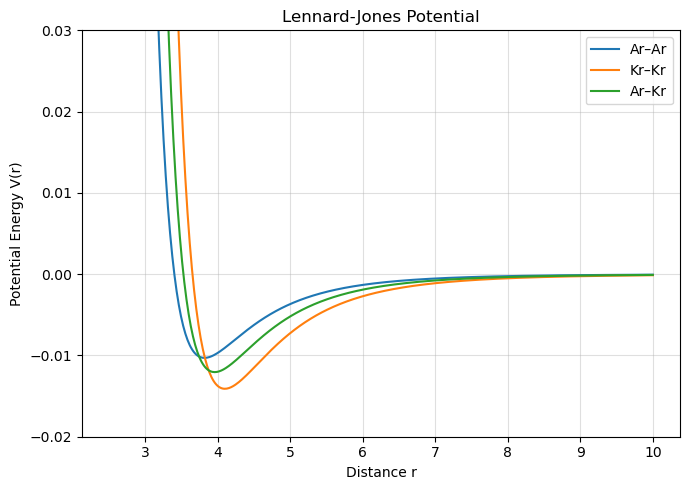

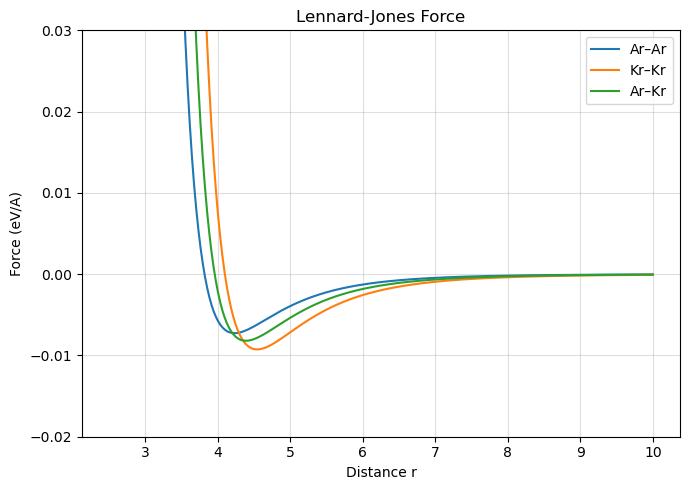

In [5]:
## collision diameter 
sigma_Ar = 3.40 # Angstrom
sigma_Kr = 3.65
sigma_Ar_Kr = (sigma_Ar+sigma_Kr)/2

## strength of the attraction
eps_Ar = 0.0103  # eV
eps_Kr = 0.0141 
eps_Ar_Kr = np.sqrt(eps_Ar*eps_Kr)

r = np.linspace(2.5,10,500)

## L-J Potentials 
V_Ar_Ar = LJ_Potential(r,eps_Ar,sigma_Ar)
V_Kr_Kr = LJ_Potential(r,eps_Kr,sigma_Kr)
V_Ar_Kr = LJ_Potential(r,eps_Ar_Kr,sigma_Ar_Kr)

## L-J Forces 
F_Ar_Ar = LJ_Force(r,eps_Ar,sigma_Ar)
F_Kr_Kr = LJ_Force(r,eps_Kr,sigma_Kr)
F_Ar_Kr = LJ_Force(r,eps_Ar_Kr,sigma_Ar_Kr)


## Plot Potential
plt.figure(figsize=(7, 5))
plt.plot(r, V_Ar_Ar, label="Ar–Ar")
plt.plot(r, V_Kr_Kr, label="Kr–Kr")
plt.plot(r, V_Ar_Kr, label="Ar–Kr")
plt.ylim(-0.02, 0.03)
plt.xlabel("Distance r")
plt.ylabel("Potential Energy V(r)")
plt.title("Lennard-Jones Potential")
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

## Plot Force
plt.figure(figsize=(7, 5))
plt.plot(r, F_Ar_Ar, label="Ar–Ar")
plt.plot(r, F_Kr_Kr, label="Kr–Kr")
plt.plot(r, F_Ar_Kr, label="Ar–Kr")
plt.ylim(-0.02, 0.03)
plt.xlabel('Distance r')
plt.ylabel('Force (eV/A)')
plt.title("Lennard-Jones Force")
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

### 2.2 Numerical Integration with Verlet Integrator

In [6]:
def velocity_verlet(r, v, a, dt, epsilon, sigma, m):
    
    r_new = r + v*dt + 0.5*a*dt**2

    F_new = LJ_Force(r_new, epsilon, sigma)
    a_new = F_new / m

    v_new = v + 0.5*(a + a_new)*dt

    return r_new, v_new, a_new

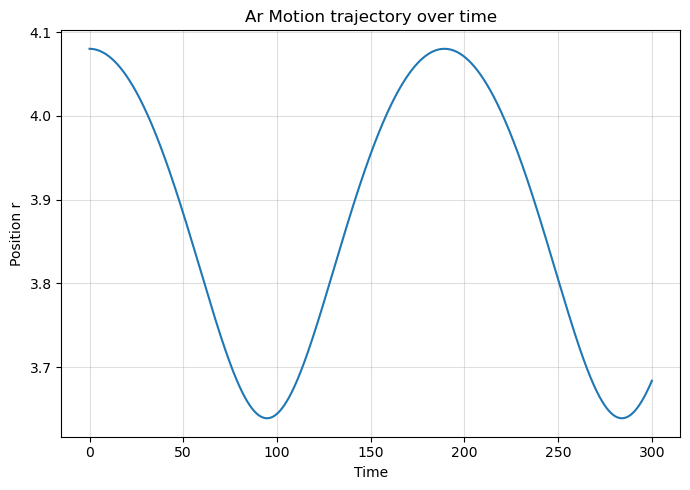

In [7]:
## Test the integrator on a single particle 
# For Ar
sigma = 3.40       # Å
epsilon = 0.0103   # eV
m = 39.95          # amu          

dt = 0.01
n_steps = 30000

r0 = 1.2*sigma
v0 = 0
F0 = LJ_Force(r0, epsilon, sigma)
a0 = F0/m

r = r0
v = v0
a = a0

r_traj = []
t_traj = []

for step in range(n_steps):
    r_traj.append(r)
    t_traj.append(step * dt)

    r, v, a = velocity_verlet(r, v, a, dt, epsilon, sigma, m)

plt.figure(figsize=(7,5))
plt.plot(t_traj, r_traj)
plt.xlabel("Time")
plt.ylabel("Position r")
plt.title("Ar Motion trajectory over time")
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

### 2.3 Simulation Setup for single Argon-Krypton pair

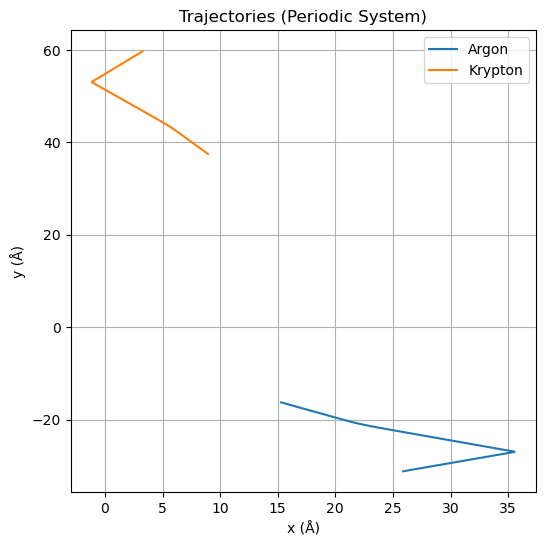

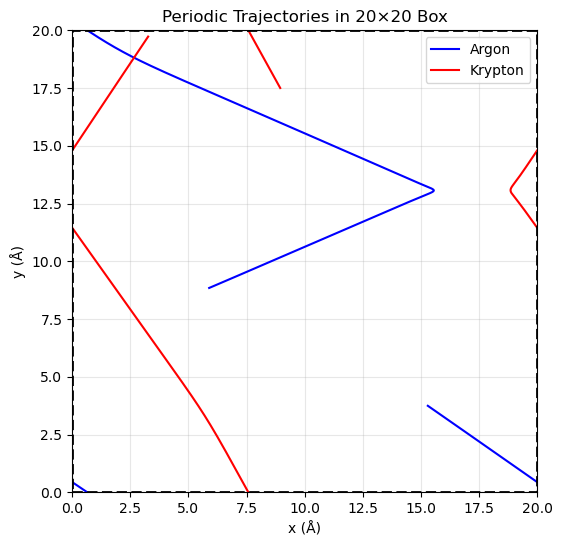

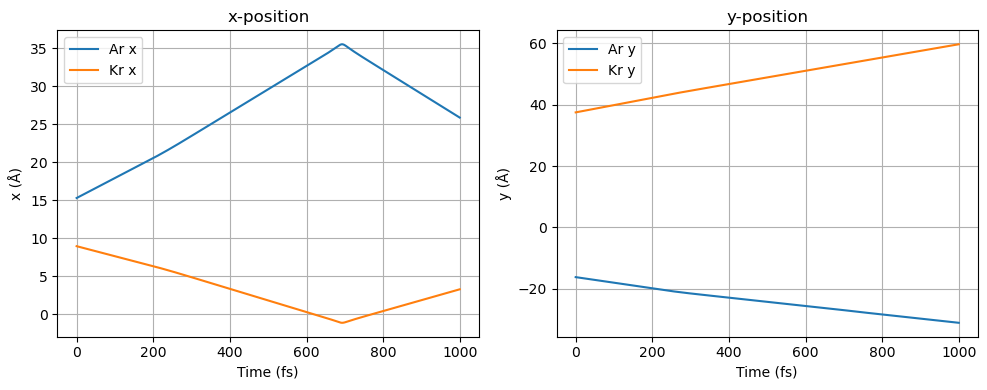

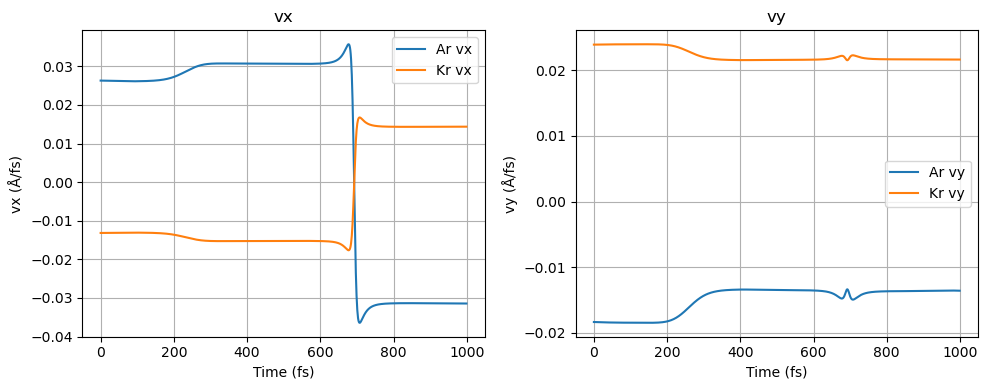

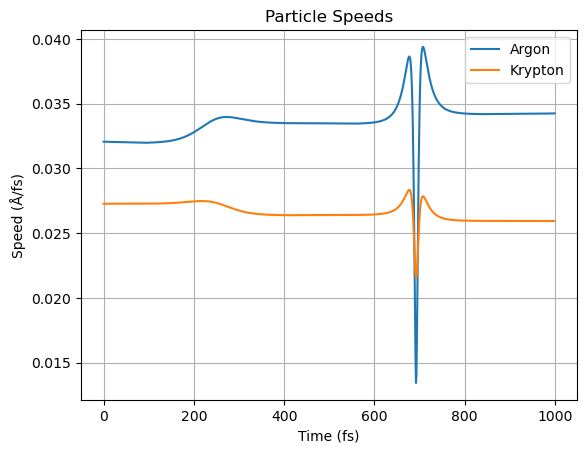

In [112]:
import numpy as np
import matplotlib.pyplot as plt

kB = 8.617333262e-5      # eV / K
L = 20.0                # Box length (Å)
dt = 1.0                # Time step (fs)
total_steps = 2000
equil_steps = 1000
T0 = 300.0              # Target temperature (K)

N = 2
masses = np.array([39.948, 83.798])  # Ar, Kr

sigma = 3.5
epsilon = 0.012

# Periodic boundary 
def apply_pbc(r):
    """Wrap positions back into box"""
    return r % L

def minimum_image(r_vec):
    """Minimum image convention"""
    return r_vec - L * np.round(r_vec / L)

# Lennard-Jones force
def LJ_force_vec(r_vec):
    r = np.linalg.norm(r_vec)
    if r == 0:
        return np.zeros(2)
    sr6 = (sigma / r)**6
    f_mag = 24 * epsilon / r * (2 * sr6**2 - sr6)
    return f_mag * r_vec / r


np.random.seed(42)

# Initial positions
r = np.array([[6.0, 10.0],
              [14.0, 10.0]])

# Velocities (Maxwell-Boltzmann)
v = np.zeros((N, 2))
for i in range(N):
    v_std = np.sqrt(kB * T0 / masses[i])
    v[i] = np.random.normal(0, v_std, size=2)

# Remove center-of-mass motion
v -= np.mean(v, axis=0)


# Initial forces
rij = minimum_image(r[1] - r[0])
fij = LJ_force_vec(rij)

F = np.zeros_like(r)
F[0] = -fij
F[1] = fij

traj_wrapped = []
traj_unwrapped = []

pos_Ar, pos_Kr = [], []
vel_Ar, vel_Kr = [], []

r_unwrap = r.copy()

# Velocity-Verlet 
for step in range(total_steps):

    # Position update
    r_new = r + v * dt + 0.5 * (F / masses[:, None]) * dt**2
    r_new = apply_pbc(r_new)

    # Unwrapping for analysis
    dr = minimum_image(r_new - r)
    r_unwrap += dr
    r = r_new

    # Force update
    rij = minimum_image(r[1] - r[0])
    fij_new = LJ_force_vec(rij)

    F_new = np.zeros_like(r)
    F_new[0] = -fij_new
    F_new[1] = fij_new

    # Velocity update
    v += 0.5 * (F + F_new) / masses[:, None] * dt
    F = F_new

    # Thermostat during equilibration
    if step < equil_steps:
        K = 0.5 * np.sum(masses[:, None] * v**2)
        T_inst = K / (N * kB)
        v *= np.sqrt(T0 / (T_inst + 1e-12))

    # Record after equilibration
    if step >= equil_steps:
        traj_wrapped.append(r.copy())
        traj_unwrapped.append(r_unwrap.copy())

        pos_Ar.append(r_unwrap[0].copy())
        pos_Kr.append(r_unwrap[1].copy())
        vel_Ar.append(v[0].copy())
        vel_Kr.append(v[1].copy())


traj_wrapped = np.array(traj_wrapped)
traj_unwrapped = np.array(traj_unwrapped)

pos_Ar = np.array(pos_Ar)
pos_Kr = np.array(pos_Kr)
vel_Ar = np.array(vel_Ar)
vel_Kr = np.array(vel_Kr)

time = np.arange(len(pos_Ar)) * dt

# Plot Trajectories 
plt.figure(figsize=(6,6))
plt.plot(pos_Ar[:,0], pos_Ar[:,1], label="Argon")
plt.plot(pos_Kr[:,0], pos_Kr[:,1], label="Krypton")
plt.xlabel("x (Å)")
plt.ylabel("y (Å)")
plt.title("Trajectories (Periodic System)")
plt.legend()
plt.grid()
plt.show()

# Plot Proper periodic trajectories inside 20×20 box
traj_wrapped = np.array(traj_wrapped) % L  

def periodic_plot(traj, L):
    x_plot = [traj[0,0]]
    y_plot = [traj[0,1]]

    for i in range(1, len(traj)):
        dx = traj[i,0] - traj[i-1,0]
        dy = traj[i,1] - traj[i-1,1]

        # If boundary crossing occurred → break line
        if abs(dx) > L/2 or abs(dy) > L/2:
            x_plot.append(np.nan)
            y_plot.append(np.nan)

        x_plot.append(traj[i,0])
        y_plot.append(traj[i,1])

    return x_plot, y_plot


# Get plot-ready trajectories
x_Ar, y_Ar = periodic_plot(traj_wrapped[:,0,:], L)
x_Kr, y_Kr = periodic_plot(traj_wrapped[:,1,:], L)


# Plot
plt.figure(figsize=(6,6))

plt.plot(x_Ar, y_Ar, label="Argon", color="blue", lw=1.5)
plt.plot(x_Kr, y_Kr, label="Krypton", color="red", lw=1.5)

# Draw simulation box
plt.plot([0, L, L, 0, 0],
         [0, 0, L, L, 0],
         'k--', lw=2)

plt.xlim(0, L)
plt.ylim(0, L)

plt.xlabel("x (Å)")
plt.ylabel("y (Å)")
plt.title("Periodic Trajectories in 20×20 Box")
plt.legend()
plt.grid(alpha=0.3)

plt.show()


# Plot Position vs Time
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(time, pos_Ar[:,0], label="Ar x")
plt.plot(time, pos_Kr[:,0], label="Kr x")
plt.xlabel("Time (fs)")
plt.ylabel("x (Å)")
plt.title("x-position")
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(time, pos_Ar[:,1], label="Ar y")
plt.plot(time, pos_Kr[:,1], label="Kr y")
plt.xlabel("Time (fs)")
plt.ylabel("y (Å)")
plt.title("y-position")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


# Plot Velocity vs Time
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(time, vel_Ar[:,0], label="Ar vx")
plt.plot(time, vel_Kr[:,0], label="Kr vx")
plt.xlabel("Time (fs)")
plt.ylabel("vx (Å/fs)")
plt.title("vx")
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(time, vel_Ar[:,1], label="Ar vy")
plt.plot(time, vel_Kr[:,1], label="Kr vy")
plt.xlabel("Time (fs)")
plt.ylabel("vy (Å/fs)")
plt.title("vy")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


# Plot Speed vs Time
speed_Ar = np.linalg.norm(vel_Ar, axis=1)
speed_Kr = np.linalg.norm(vel_Kr, axis=1)

plt.figure()
plt.plot(time, speed_Ar, label="Argon")
plt.plot(time, speed_Kr, label="Krypton")
plt.xlabel("Time (fs)")
plt.ylabel("Speed (Å/fs)")
plt.title("Particle Speeds")
plt.legend()
plt.grid()
plt.show()


## Section 3: Thermodynamic Properties and Data Analysis

### 3.1 Calculating Temperature and Pressure

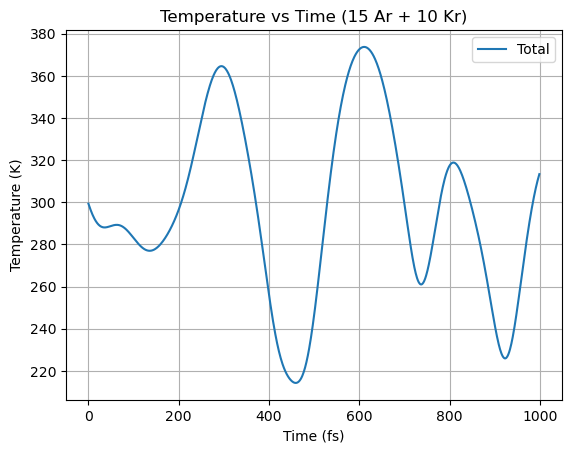

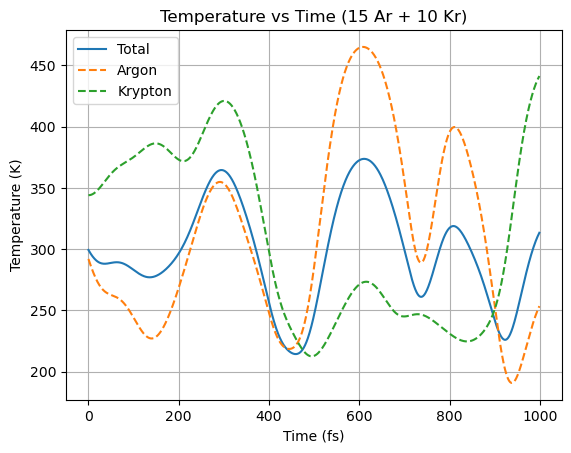

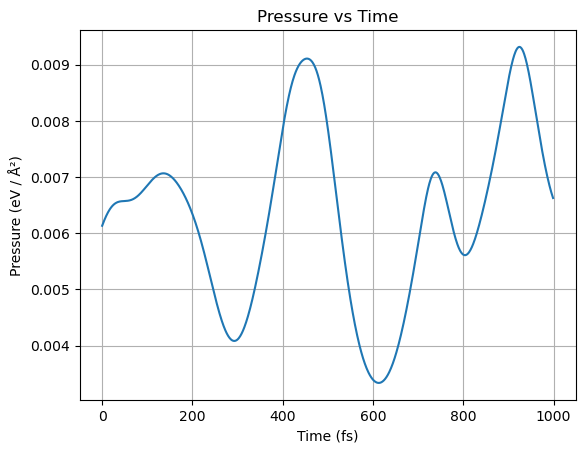

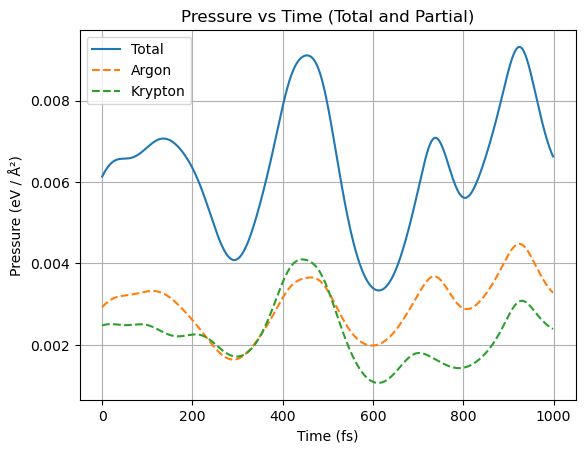

In [91]:
import numpy as np
import matplotlib.pyplot as plt


kB = 8.617333262e-5       # eV / K
amu_to_md = 103.6427     # amu → eV·fs²/Å²


L = 20.0                 # box length (Å)
A = L * L                # area (2D)
dt = 1.0                 # timestep (fs)
total_steps = 2000
equil_steps = 1000
T0 = 300.0               # target temperature (K)


N_Ar = 15
N_Kr = 10
N = N_Ar + N_Kr          # total atoms
d = 2

sigma_Ar = 3.40
sigma_Kr = 3.65
epsilon_Ar = 0.0103
epsilon_Kr = 0.0141

sigma_mix = 0.5 * (sigma_Ar + sigma_Kr)
epsilon_mix = np.sqrt(epsilon_Ar * epsilon_Kr)


m_Ar = 39.948 * amu_to_md
m_Kr = 83.798 * amu_to_md

masses = np.array([m_Ar]*N_Ar + [m_Kr]*N_Kr)
types = np.array(["Ar"]*N_Ar + ["Kr"]*N_Kr)

def apply_pbc(r, L):
    return r - L * np.round(r / L)


# Lennard-Jones force

def LJ_force_vec(r_vec, epsilon, sigma):
    r = np.linalg.norm(r_vec)
    if r == 0:
        return np.zeros(2)
    sr6 = (sigma / r)**6
    f_mag = 24 * epsilon / r * (2 * sr6**2 - sr6)
    return f_mag * r_vec / r


np.random.seed(1)

r = np.random.uniform(0, L, size=(N, 2))
v = np.zeros((N, 2))

for i in range(N):
    v_std = np.sqrt(kB * T0 / masses[i])
    v[i] = np.random.normal(0, v_std, size=2)

# Remove center-of-mass motion
v -= np.mean(v, axis=0)

def compute_forces(r):
    F = np.zeros_like(r)
    virial_total = 0.0
    virial_Ar = 0.0
    virial_Kr = 0.0

    for i in range(N):
        for j in range(i + 1, N):
            rij = apply_pbc(r[j] - r[i], L)

            if types[i] == "Ar" and types[j] == "Ar":
                sigma, epsilon = sigma_Ar, epsilon_Ar
            elif types[i] == "Kr" and types[j] == "Kr":
                sigma, epsilon = sigma_Kr, epsilon_Kr
            else:
                sigma, epsilon = sigma_mix, epsilon_mix

            fij = LJ_force_vec(rij, epsilon, sigma)

            F[i] -= fij
            F[j] += fij

            vij = np.dot(rij, fij)
            virial_total += vij

            if types[i] == "Ar" or types[j] == "Ar":
                virial_Ar += 0.5 * vij
            if types[i] == "Kr" or types[j] == "Kr":
                virial_Kr += 0.5 * vij

    return F, virial_total, virial_Ar, virial_Kr

F, _, _, _ = compute_forces(r)

t_traj = []
T_series = []
T_Ar_series = []
T_Kr_series = []
P_series = []
P_Ar_series = []
P_Kr_series = []


# Velocity Verlet integration

for step in range(total_steps):

    # Update positions
    r += v * dt + 0.5 * (F / masses[:, None]) * dt**2
    r = apply_pbc(r, L)

    # New forces
    F_new, virial, virial_Ar, virial_Kr = compute_forces(r)

    # Update velocities
    v += 0.5 * (F + F_new) / masses[:, None] * dt
    F = F_new

    # Equilibration: velocity rescaling
    if step < equil_steps:
        K = 0.5 * np.sum(masses[:, None] * v**2)
        T_inst = 2 * K / ((2 * N - 2) * kB)
        v *= np.sqrt(T0 / T_inst)

    # Measurements
    if step >= equil_steps:
        t = (step - equil_steps) * dt

        K = 0.5 * np.sum(masses[:, None] * v**2)
        T = 2 * K / ((2 * N - 2) * kB)

        v_Ar = v[types == "Ar"]
        v_Kr = v[types == "Kr"]

        K_Ar = 0.5 * m_Ar * np.sum(v_Ar**2)
        K_Kr = 0.5 * m_Kr * np.sum(v_Kr**2)

        T_Ar = 2 * K_Ar / ((2 * N_Ar - 2) * kB)
        T_Kr = 2 * K_Kr / ((2 * N_Kr - 2) * kB)

        P = (N * kB * T) / A + virial / (2 * A)
        P_Ar = (N_Ar * kB * T_Ar) / A + virial_Ar / (2 * A)
        P_Kr = (N_Kr * kB * T_Kr) / A + virial_Kr / (2 * A)

        t_traj.append(t)
        T_series.append(T)
        T_Ar_series.append(T_Ar)
        T_Kr_series.append(T_Kr)
        P_series.append(P)
        P_Ar_series.append(P_Ar)
        P_Kr_series.append(P_Kr)



t_traj = np.array(t_traj)
T_series = np.array(T_series)
T_Ar_series = np.array(T_Ar_series)
T_Kr_series = np.array(T_Kr_series)
P_series = np.array(P_series)
P_Ar_series = np.array(P_Ar_series)
P_Kr_series = np.array(P_Kr_series)

plt.figure()
plt.plot(t_traj, T_series, label="Total")
plt.xlabel("Time (fs)")
plt.ylabel("Temperature (K)")
plt.title("Temperature vs Time (15 Ar + 10 Kr)")
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.plot(t_traj, T_series, label="Total")
plt.plot(t_traj, T_Ar_series, "--", label="Argon")
plt.plot(t_traj, T_Kr_series, "--", label="Krypton")
plt.xlabel("Time (fs)")
plt.ylabel("Temperature (K)")
plt.title("Temperature vs Time (15 Ar + 10 Kr)")
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.plot(t_traj, P_series)
plt.xlabel("Time (fs)")
plt.ylabel("Pressure (eV / Å²)")
plt.title("Pressure vs Time")
plt.grid()
plt.show()

plt.figure()
plt.plot(t_traj, P_series, label="Total")
plt.plot(t_traj, P_Ar_series, "--", label="Argon")
plt.plot(t_traj, P_Kr_series, "--", label="Krypton")
plt.xlabel("Time (fs)")
plt.ylabel("Pressure (eV / Å²)")
plt.title("Pressure vs Time (Total and Partial)")
plt.legend()
plt.grid()
plt.show()



### 3.2 Radial Distribution Function (g(r))

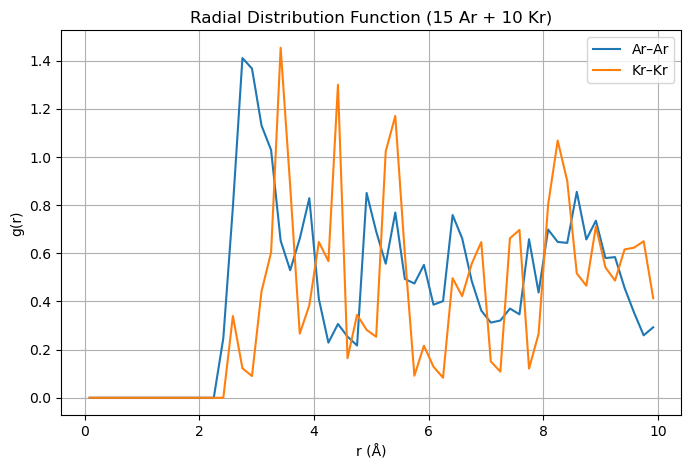

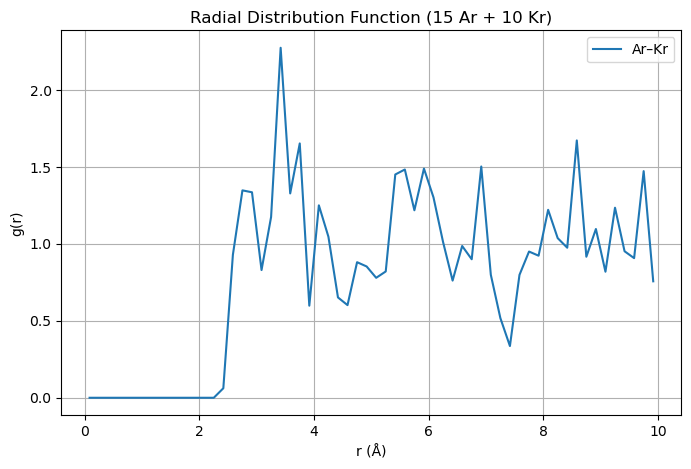

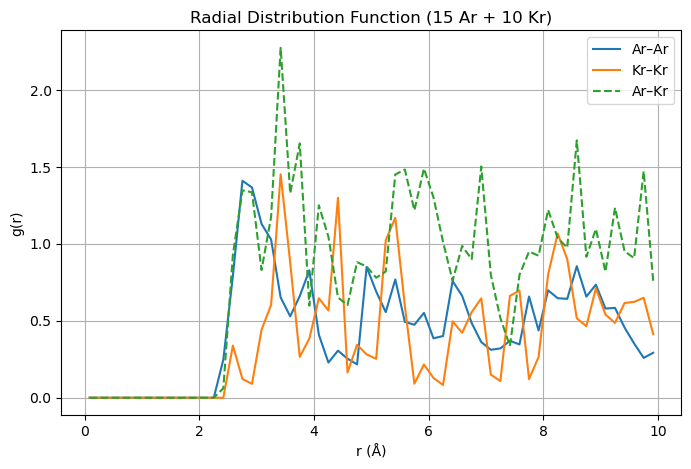

In [94]:
import numpy as np
import matplotlib.pyplot as plt


kB = 8.617333262e-5   # eV / K
L = 20.0              # box length (Å)
A = L * L
dt = 0.005
total_steps = 3000
equil_steps = 1500
T0 = 300.0

N_Ar = 15
N_Kr = 10
N = N_Ar + N_Kr
d = 2

types = np.array(["Ar"] * N_Ar + ["Kr"] * N_Kr)


# Lennard-Jones parameters

sigma_Ar, epsilon_Ar = 3.40, 0.0103
sigma_Kr, epsilon_Kr = 3.65, 0.0141
sigma_mix = 0.5 * (sigma_Ar + sigma_Kr)
epsilon_mix = np.sqrt(epsilon_Ar * epsilon_Kr)

m_Ar, m_Kr = 39.948, 83.798
masses = np.array([m_Ar]*N_Ar + [m_Kr]*N_Kr)

def apply_pbc(r, L):
    return r - L * np.round(r / L)

def LJ_force_vec(r_vec, epsilon, sigma):
    r = np.linalg.norm(r_vec)
    if r == 0:
        return np.zeros(2)
    sr6 = (sigma / r)**6
    f_mag = 24 * epsilon / r * (2 * sr6**2 - sr6)
    return f_mag * r_vec / r

np.random.seed(1)
r = np.random.uniform(0, L, size=(N, 2))
v = np.zeros((N, 2))

for i in range(N):
    v_std = np.sqrt(kB * T0 / masses[i])
    v[i] = np.random.normal(0, v_std, size=2)

v -= np.mean(v, axis=0)

def compute_forces(r):
    F = np.zeros_like(r)
    virial = 0.0

    distances = {"Ar-Ar": [], "Kr-Kr": [], "Ar-Kr": []}

    for i in range(N):
        for j in range(i + 1, N):
            rij = apply_pbc(r[j] - r[i], L)
            r_mag = np.linalg.norm(rij)

            if types[i] == "Ar" and types[j] == "Ar":
                sigma, eps, key = sigma_Ar, epsilon_Ar, "Ar-Ar"
            elif types[i] == "Kr" and types[j] == "Kr":
                sigma, eps, key = sigma_Kr, epsilon_Kr, "Kr-Kr"
            else:
                sigma, eps, key = sigma_mix, epsilon_mix, "Ar-Kr"

            fij = LJ_force_vec(rij, eps, sigma)
            F[i] -= fij
            F[j] += fij
            virial += np.dot(rij, fij)

            distances[key].append(r_mag)

    return F, virial, distances

F, _, _ = compute_forces(r)

all_dist = {"Ar-Ar": [], "Kr-Kr": [], "Ar-Kr": []}

for step in range(total_steps):

    r += v * dt + 0.5 * (F / masses[:, None]) * dt**2
    r = apply_pbc(r, L)

    F_new, _, dist = compute_forces(r)
    v += 0.5 * (F + F_new) / masses[:, None] * dt
    F = F_new

    if step < equil_steps:
        K = 0.5 * np.sum(masses[:, None] * v**2)
        T_inst = 2 * K / ((2*N - 2) * kB)
        v *= np.sqrt(T0 / T_inst)

    if step >= equil_steps:
        for key in all_dist:
            all_dist[key].extend(dist[key])


# g(r) calculation 
def calculate_gr(distances, N1, N2, L, n_bins=60):
    distances = np.array(distances)
    dr = (L/2) / n_bins

    hist, edges = np.histogram(distances, bins=n_bins, range=(0, L/2))
    r = edges[:-1] + dr/2

    n_frames = total_steps - equil_steps
    rho = N2 / (L**2)

    g = hist / (n_frames * N1 * rho * 2 * np.pi * r * dr)
    return r, g

# Correct normalization
r_AA, g_AA = calculate_gr(all_dist["Ar-Ar"], N_Ar, N_Ar-1, L)
r_KK, g_KK = calculate_gr(all_dist["Kr-Kr"], N_Kr, N_Kr-1, L)
r_AK, g_AK = calculate_gr(all_dist["Ar-Kr"], N_Ar, N_Kr, L)

plt.figure(figsize=(8,5))
plt.plot(r_AA, g_AA, label="Ar–Ar")
plt.plot(r_KK, g_KK, label="Kr–Kr")
plt.xlabel("r (Å)")
plt.ylabel("g(r)")
plt.title("Radial Distribution Function (15 Ar + 10 Kr)")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(r_AK, g_AK, label="Ar–Kr")
plt.xlabel("r (Å)")
plt.ylabel("g(r)")
plt.title("Radial Distribution Function (15 Ar + 10 Kr)")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(r_AA, g_AA, label="Ar–Ar")
plt.plot(r_KK, g_KK, label="Kr–Kr")
plt.plot(r_AK, g_AK, "--", label="Ar–Kr")
plt.xlabel("r (Å)")
plt.ylabel("g(r)")
plt.title("Radial Distribution Function (15 Ar + 10 Kr)")
plt.legend()
plt.grid()
plt.show()

### 3.3 Dynamic Properties

D_Ar = 6.0309e-04 Å²/fs
D_Kr = 6.6965e-04 Å²/fs


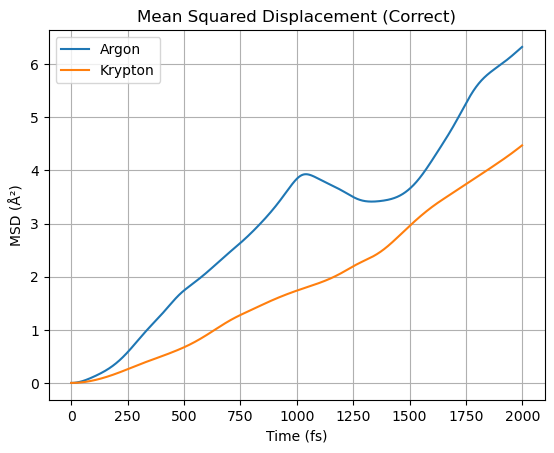

In [104]:
import numpy as np
import matplotlib.pyplot as plt

kB = 8.617333262e-5          # eV/K
amu_to_md = 103.6427        # amu → eV·fs²/Å²

L = 20.0                    # box length (Å)
A = L * L
dt = 1.0                    # timestep (fs)
total_steps = 4000
equil_steps = 2000
T0 = 300.0                  # target temperature (K)
d = 2

N_Ar = 15
N_Kr = 10
N = N_Ar + N_Kr

sigma_Ar, epsilon_Ar = 3.40, 0.0103
sigma_Kr, epsilon_Kr = 3.65, 0.0141
sigma_mix = 0.5 * (sigma_Ar + sigma_Kr)
epsilon_mix = np.sqrt(epsilon_Ar * epsilon_Kr)


m_Ar = 39.948 * amu_to_md
m_Kr = 83.798 * amu_to_md

masses = np.array([m_Ar]*N_Ar + [m_Kr]*N_Kr)
types = np.array(["Ar"]*N_Ar + ["Kr"]*N_Kr)


def apply_pbc(r):
    return r - L * np.round(r / L)

def LJ_force_vec(r_vec, epsilon, sigma):
    r = np.linalg.norm(r_vec)
    if r == 0:
        return np.zeros(2)
    sr6 = (sigma / r)**6
    f_mag = 24 * epsilon / r * (2*sr6**2 - sr6)
    return f_mag * r_vec / r


np.random.seed(1)

r = np.random.uniform(0, L, size=(N, 2))
r_unwrapped = r.copy()
v = np.zeros((N, 2))

for i in range(N):
    v_std = np.sqrt(kB * T0 / masses[i])
    v[i] = np.random.normal(0, v_std, size=2)

# Remove center-of-mass motion
v -= np.mean(v, axis=0)

# Force calculation

def compute_forces(r):
    F = np.zeros_like(r)
    virial = 0.0

    for i in range(N):
        for j in range(i+1, N):
            rij = apply_pbc(r[j] - r[i])

            if types[i] == "Ar" and types[j] == "Ar":
                sigma, eps = sigma_Ar, epsilon_Ar
            elif types[i] == "Kr" and types[j] == "Kr":
                sigma, eps = sigma_Kr, epsilon_Kr
            else:
                sigma, eps = sigma_mix, epsilon_mix

            fij = LJ_force_vec(rij, eps, sigma)
            F[i] -= fij
            F[j] += fij
            virial += np.dot(rij, fij)

    return F, virial

F, _ = compute_forces(r)

traj_Ar, traj_Kr = [], []
vel_Ar, vel_Kr = [], []
T_series = []

# Velocity Verlet MD
for step in range(total_steps):

    #  position update
    dr = v * dt + 0.5 * (F / masses[:, None]) * dt**2
    r_unwrapped += dr
    r = apply_pbc(r_unwrapped)

    #  forces 
    F_new, virial = compute_forces(r)

    #  velocity update 
    v += 0.5 * (F + F_new) / masses[:, None] * dt
    F = F_new

    #  thermostat during equilibration 
    if step < equil_steps:
        K = 0.5 * np.sum(masses[:,None] * v**2)
        T_inst = 2*K / ((2*N - 2)*kB)
        v *= np.sqrt(T0 / T_inst)

    if step >= equil_steps:
        traj_Ar.append(r_unwrapped[types=="Ar"])
        traj_Kr.append(r_unwrapped[types=="Kr"])
        vel_Ar.append(v[types=="Ar"])
        vel_Kr.append(v[types=="Kr"])

        K = 0.5 * np.sum(masses[:,None] * v**2)
        T_series.append(2*K / ((2*N - 2)*kB))

traj_Ar = np.array(traj_Ar)
traj_Kr = np.array(traj_Kr)
vel_Ar = np.array(vel_Ar)
vel_Kr = np.array(vel_Kr)

time = np.arange(len(traj_Ar)) * dt

# MSD & Diffusion 
def compute_msd(traj):
    dr = traj - traj[0]
    return np.mean(np.sum(dr**2, axis=2), axis=1)

msd_Ar = compute_msd(traj_Ar)
msd_Kr = compute_msd(traj_Kr)

fit_start = int(0.4 * len(time))
D_Ar = np.polyfit(time[fit_start:], msd_Ar[fit_start:], 1)[0] / 4
D_Kr = np.polyfit(time[fit_start:], msd_Kr[fit_start:], 1)[0] / 4

print(f"D_Ar = {D_Ar:.4e} Å²/fs")
print(f"D_Kr = {D_Kr:.4e} Å²/fs")

plt.figure()
plt.plot(time, msd_Ar, label="Argon")
plt.plot(time, msd_Kr, label="Krypton")
plt.xlabel("Time (fs)")
plt.ylabel("MSD (Å²)")
plt.title("Mean Squared Displacement (Correct)")
plt.legend()
plt.grid()
plt.show()

# Velocity Distribution
vAr = np.linalg.norm(vel_Ar.reshape(-1,2), axis=1)
vKr = np.linalg.norm(vel_Kr.reshape(-1,2), axis=1)

def maxwell_2d(v, m, T):
    return (m/(kB*T)) * v * np.exp(-m*v**2/(2*kB*T))

vgrid = np.linspace(0, max(vAr.max(), vKr.max()), 300)
Tavg = np.mean(T_series)


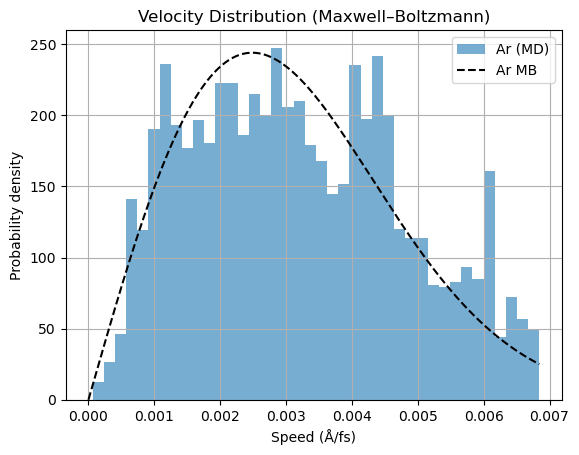

In [105]:
plt.figure()
plt.hist(vAr, bins=40, density=True, alpha=0.6, label="Ar (MD)")
plt.plot(vgrid, maxwell_2d(vgrid, m_Ar, Tavg), 'k--', label="Ar MB")
plt.xlabel("Speed (Å/fs)")
plt.ylabel("Probability density")
plt.title("Velocity Distribution (Maxwell–Boltzmann)")
plt.legend()
plt.grid()
plt.show()

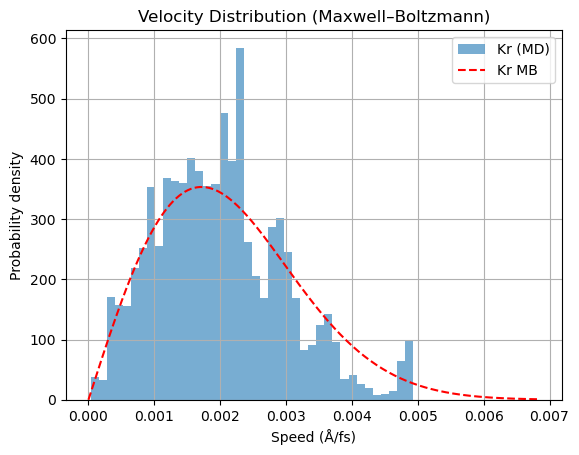

In [106]:
plt.figure()
plt.hist(vKr, bins=40, density=True, alpha=0.6, label="Kr (MD)")
plt.plot(vgrid, maxwell_2d(vgrid, m_Kr, Tavg), 'r--', label="Kr MB")
plt.xlabel("Speed (Å/fs)")
plt.ylabel("Probability density")
plt.title("Velocity Distribution (Maxwell–Boltzmann)")
plt.legend()
plt.grid()
plt.show()

## Section 4: Advanced Topics
### 4.1 Diatomic Molecule Simulation

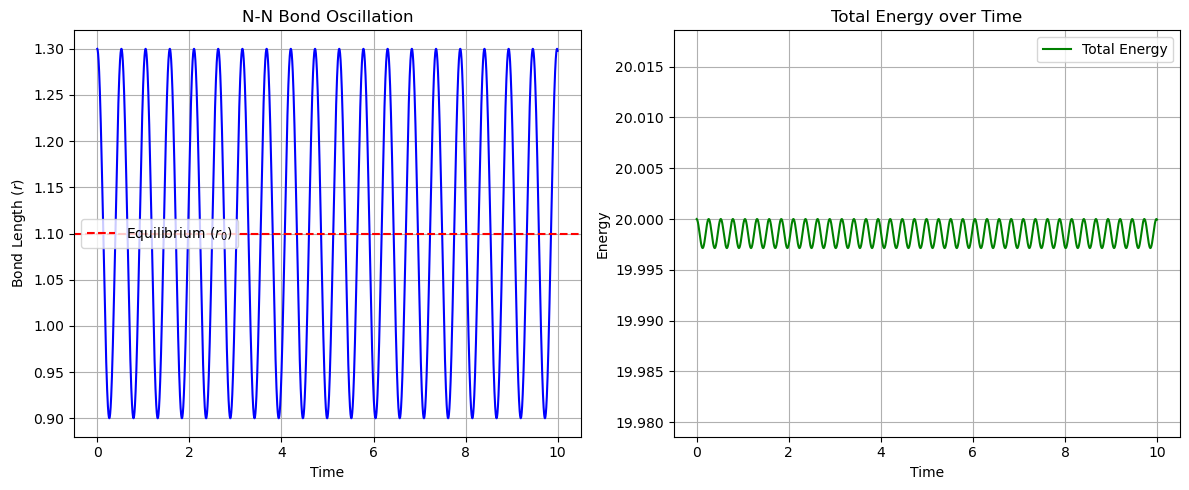

In [107]:
import numpy as np
import matplotlib.pyplot as plt

mass = 14.0        
# Spring constant (Bond stiffness)
k_bond = 1000.0    
# Equilibrium bond length (r0)
r0 = 1.1           
# Simulation time step
dt = 0.002         
# Total number of steps
steps = 5000       

pos1 = np.array([0.0, 0.0])
pos2 = np.array([r0 + 0.2, 0.0]) 

# Initial velocities 
vel1 = np.array([0.0, 0.0])
vel2 = np.array([0.0, 0.0])

time_log = []
distance_log = []
energy_log = []

#  3. Velocity Verlet Integration
def compute_force(p1, p2):

    r_vec = p2 - p1
    r_mag = np.linalg.norm(r_vec)

    force_magnitude = -k_bond * (r_mag - r0)

    direction = r_vec / r_mag
    
    # Force vector on Atom 2
    f2 = force_magnitude * direction
    # Force on Atom 1 is opposite (Newton's 3rd Law)
    f1 = -f2
    
    # Potential Energy: V = 0.5 * k * (r - r0)^2
    pe = 0.5 * k_bond * (r_mag - r0)**2
    
    return f1, f2, pe

# Initial force calculation
f1, f2, pe = compute_force(pos1, pos2)

for step in range(steps):
    t = step * dt
    
    # A. First Verlet update: Position
    # x(t+dt) = x(t) + v(t)dt + 0.5*a(t)dt^2
    pos1 += vel1 * dt + 0.5 * (f1 / mass) * dt**2
    pos2 += vel2 * dt + 0.5 * (f2 / mass) * dt**2
    
    # B. Compute new forces at new positions
    f1_new, f2_new, pe_new = compute_force(pos1, pos2)
    
    # C. Second Verlet update: Velocity
    # v(t+dt) = v(t) + 0.5 * (a(t) + a(t+dt)) * dt
    vel1 += 0.5 * ((f1 + f1_new) / mass) * dt
    vel2 += 0.5 * ((f2 + f2_new) / mass) * dt
    
    # Update forces for next loop
    f1, f2, pe = f1_new, f2_new, pe_new
    
    # D. Logging Data
    dist = np.linalg.norm(pos2 - pos1)
    ke = 0.5 * mass * np.sum(vel1**2) + 0.5 * mass * np.sum(vel2**2)
    
    time_log.append(t)
    distance_log.append(dist)
    energy_log.append(ke + pe)

# --- 4. Visualization ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Bond Length vs Time
ax1.plot(time_log, distance_log, color='blue')
ax1.axhline(r0, color='red', linestyle='--', label='Equilibrium ($r_0$)')
ax1.set_title('N-N Bond Oscillation')
ax1.set_xlabel('Time')
ax1.set_ylabel('Bond Length ($r$)')
ax1.legend()
ax1.grid(True)

# Plot 2: Energy Conservation
ax2.plot(time_log, energy_log, color='green', label='Total Energy')
ax2.set_title('Total Energy over Time')
ax2.set_xlabel('Time')
ax2.set_ylabel('Energy')
# Zoom the y-axis to show stability
y_center = np.mean(energy_log)
ax2.set_ylim(y_center * 0.999, y_center * 1.001) 
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

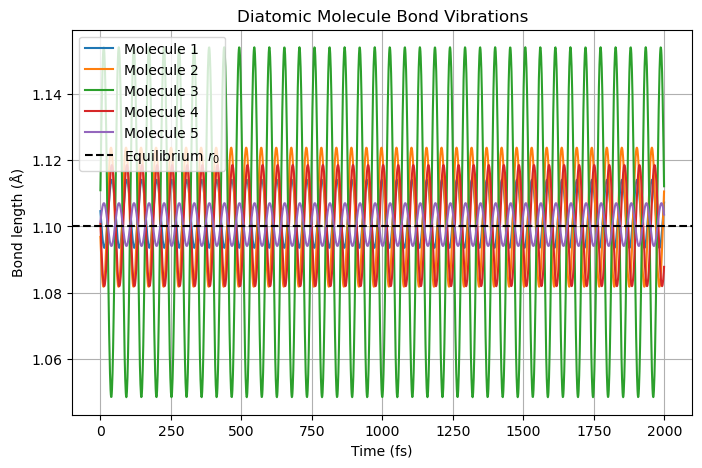

In [108]:
import numpy as np
import matplotlib.pyplot as plt

kB = 8.617333262e-5      # eV/K
amu_to_md = 103.6427    # amu → eV·fs²/Å²

dt = 1.0                # fs
total_steps = 3000
equil_steps = 1000
T0 = 300.0              # K
L = 30.0                # box size (Å)
d = 2

N_mol = 5               # number of diatomic molecules
N = 2 * N_mol           # total atoms

m_N = 14.0 * amu_to_md  # nitrogen mass
masses = np.array([m_N] * N)

# Harmonic bond parameters
r0 = 1.1                # equilibrium bond length (Å)
k_bond = 10.0           # bond spring constant (eV/Å²)

def apply_pbc(r):
    return r - L * np.round(r / L)

# Harmonic bond force
def bond_force(rij):
    r = np.linalg.norm(rij)
    if r == 0:
        return np.zeros(2)
    f_mag = -k_bond * (r - r0)
    return f_mag * rij / r

np.random.seed(1)

r = np.zeros((N, 2))
v = np.zeros((N, 2))

# Place molecules randomly
for i in range(N_mol):
    center = np.random.uniform(0, L, size=2)
    direction = np.random.normal(size=2)
    direction /= np.linalg.norm(direction)

    r[2*i]   = center - 0.5 * r0 * direction
    r[2*i+1] = center + 0.5 * r0 * direction

# Initialize velocities
for i in range(N):
    v_std = np.sqrt(kB * T0 / masses[i])
    v[i] = np.random.normal(0, v_std, size=2)

# Remove center-of-mass motion
v -= np.mean(v, axis=0)

def compute_forces(r):
    F = np.zeros_like(r)
    bond_lengths = []

    for i in range(N_mol):
        a = 2*i
        b = 2*i + 1

        rij = apply_pbc(r[b] - r[a])
        fij = bond_force(rij)

        F[a] -= fij
        F[b] += fij

        bond_lengths.append(np.linalg.norm(rij))

    return F, np.array(bond_lengths)

# Initial forces
F, _ = compute_forces(r)

bond_history = []

# Velocity Verlet integration

for step in range(total_steps):

    # Update positions
    r += v * dt + 0.5 * (F / masses[:, None]) * dt**2
    r = apply_pbc(r)

    # New forces
    F_new, bonds = compute_forces(r)

    # Update velocities
    v += 0.5 * (F + F_new) / masses[:, None] * dt
    F = F_new

    # Simple thermostat during equilibration
    if step < equil_steps:
        K = 0.5 * np.sum(masses[:, None] * v**2)
        T_inst = 2 * K / ((2*N - 2) * kB)
        v *= np.sqrt(T0 / T_inst)

    if step >= equil_steps:
        bond_history.append(bonds)

bond_history = np.array(bond_history)
time = np.arange(len(bond_history)) * dt

plt.figure(figsize=(8,5))
for i in range(N_mol):
    plt.plot(time, bond_history[:, i], label=f"Molecule {i+1}")

plt.axhline(r0, color='k', linestyle='--', label="Equilibrium $r_0$")
plt.xlabel("Time (fs)")
plt.ylabel("Bond length (Å)")
plt.title("Diatomic Molecule Bond Vibrations")
plt.legend()
plt.grid()
plt.show()
